<a href="https://colab.research.google.com/github/project-ida/arpa-e-experiments/blob/neutrons-background-2/tutorials/He3-Background-Characterization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="https://nbviewer.org/github/project-ida/arpa-e-experiments/blob/neutrons-background-2/tutorials/He3-Background-Characterization.ipynb" target="_parent"><img src="https://nbviewer.org/static/img/nav_logo.svg" alt="Open In nbviewer" width="100"/></a>

# Helium-3 Detector Background Characterization

### Prequel - What's a Helium-3 detector ?

Before we jump into background characterization, let's recall how these nuclear particle detectors work.

Helium-3 (³He) detectors are gas-filled proportional counters widely used for detecting thermal neutrons. When a thermal neutron enters the detector, it interacts with a ³He nucleus via the reaction:

$$
n + {}^3\text{He} \rightarrow p + {}^3\text{H} + 764\,\text{keV}
$$

This reaction produces a proton and a triton (³H), which ionize the surrounding gas. The resulting charge is collected by an anode wire, and the induced current is amplified to produce a measurable signal. The signal amplitude is proportional to the energy deposited and provides a clear signature of neutron interactions.


## Experimental Setup - Our Helium-3 Detectors

We are running experiments in which we are looking out for the production of neutrons. In order to characterize these bursts, we need to be certain of the background levels against which we are comparing our experimental data.

In the lab, we have access to Helium-3 tubes. In this notebook, our goal is to set up a precedure for characterizing the background of one of these detectors from a "long" (~1 month) background measurement. More specifically, we would like to characterize the probabilistic distribution of the background counts picked up by a single Helium-3 detector and set up a protocol to use statistical tests to determine whether certain counts or bursts are background or events of significance in  experiments.

In order to do so, we began by running the detector in question throughout December 2024 and January 2025. On December 17th, we introduced a neutron source, ²⁵²Cf to collect some callibration data. We will now characterize this background, which will be useful for future analysis.

The data panel describing this background measurement can be found [here](https://lenr.mit.edu/data/load-panel.php?filename=he3-detectors-background).

In [1]:
# RUN THIS IF YOU ARE USING GOOGLE COLAB
import sys
import os
!git clone https://github.com/project-ida/arpa-e-experiments.git
sys.path.insert(0,'/content/arpa-e-experiments')
os.chdir('/content/arpa-e-experiments')

Cloning into 'arpa-e-experiments'...
remote: Enumerating objects: 356, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 356 (delta 59), reused 45 (delta 27), pack-reused 265 (from 1)
Receiving objects: 100% (356/356), 30.15 MiB | 6.22 MiB/s, done.
Resolving deltas: 100% (193/193), done.
Updating files: 100% (54/54), done.


In [3]:
# RUN THIS IF YOU ARE LOCAL.
# It makes sure we can import helpers from libs which is one level up

import sys
import os

# Get the parent directory (one level up from the current directory)
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the parent directory to sys.path
sys.path.insert(0, project_root)

In [4]:
# Libraries and helper functions

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import norm
from scipy.stats import poisson
from IPython.display import display

from IPython.display import Image
from IPython.display import Video
from IPython.display import HTML

# Use our custom helper functions
# - process_data
# - plot_panels
# - plot_panels_with_scatter
# - print_info
from libs.helpers import *

In [5]:
meta = {
    "descriptor" : "He-3 12-2024" # This will go into the title of all plots
}

## Step 1 – Data Collection

Let’s begin by collecting raw data from the Helium-3 neutron detectors.

We have collected long-term time-resolved background data using our Helium-3 detectors, covering the period from December 14th, 2024 at 00:01:01 to January 23rd, 2025 at 23:58:59. These data consist of neutron counts recorded at regular time intervals.

We store the data as pandas DataFrames, which allows us to easily manipulate, visualize, and analyze the results in the steps that follow.

In [ ]:
he3_dec = pd.read_csv(
    'http://nucleonics.mit.edu/csv-files/he3-detectors-background2-2.csv',
    parse_dates=['time'],
    date_format="ISO8601",
    index_col='time'
)

he3_jan = pd.read_csv(
    'http://nucleonics.mit.edu/csv-files/he3-detectors-background-2.csv',
    parse_dates=['time'],
    date_format="ISO8601",
    index_col='time'
)

# To facilitate our analysis, let's concatenate december and january
he3_all = pd.concat([he3_dec, he3_jan])
he3_all = he3_all.sort_index()


In [9]:
he3_all

,Counts ch50-1000
time,
2024-12-19 00:02:16,16.0
2024-12-19 00:03:31,13.0
2024-12-19 00:04:47,13.0
2024-12-19 00:06:02,13.0
2024-12-19 00:07:17,10.0
...,...
2025-01-15 23:47:05,14.0
2025-01-15 23:49:24,6.0
2025-01-15 23:51:42,8.0


In [7]:
# We will also begin numbering our figures here for easier reference later in the notebook
fig_counter = 0

## Step 2 - Visualizing Neutron counts

Now that we have collected the raw data (i.e. electric signal history) that interests us, let us have a look at the measured neutron and gamma counts.

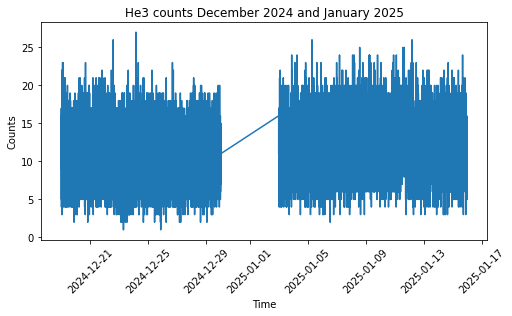

In [8]:
plt.figure(figsize=(8, 4))
plt.plot(he3_all['Counts ch50-1000'])
plt.xlabel('Time')
plt.ylabel('Counts')
plt.xticks(rotation=45)
plt.title(f"He3 counts December 2024 and January 2025")
plt.show()
# plt.savefig("He3-counts-dec.png", dpi=600)

We know from the statistical analysis of our 2" Eljen detector that a Cf-252 source was introduced in the lab on December 17- 18th 2024. To the naked eye, this is not necessarily visible. 

## Step 3 - Resampling Data and Removing Neutron Burst from Background Data

The current data is taken about once per second. We'll now aggregate this data to present counts in 1 minute intervals.

This is an arbitrary choice, but will allow us to develop some intuition about count binning. Indeed, larger time intervals will necessarily include more counts, so it will be easier to distinguish by eye any significant events. This is not nessecarily the method we will keep for further analysis, given its dependence on an arbitrary bin choice, but it remains useful in our intuition building. In the future, we hope to remove the arbitrarity of binning all together (see later notebook introduced in last section of this notebook).

Furthermore, we commented earlier on a neutron and gamma burst begining on December 17th. This corresponded to a time-period in which we brought a ²⁵²Cf neutron source into the lab (i.e. the bursts that the detectors are picking up). Hence, in order to define a clear background time, we will start collecting data from December 19th.

So, in sum, our next step is to :

1. **Aggregate** the raw second-by-second counts into 1 minute bins.  
2. **Exclude** the burst period when the ²⁵²Cf source was in the lab, and begin our background analysis on December 19th.

In [14]:
he3_df_1_minute = he3_all.resample('1min').sum()

# Assuming neutron_df_1_minute has a datetime index
start_time = "2024-12-19 00:00:00"
end_time = "2025-01-23 23:59:00"

he3_df_1_minute_background = he3_df_1_minute.loc[start_time:end_time]
he3_df_1_minute_background.rename(columns={"Counts ch50-1000": "Counts"}, inplace=True)
he3_df_1_minute_background.index = pd.to_datetime(he3_df_1_minute_background.index)


## Step 4 - Analyzing the Measured Background Counts

Now that we have excluded the time before and when the neutron source was introduced, let us take a closer look at our background neutron counts.

Here are the different steps we will take:

**Side-step 4.1 Expected Poisson Distribution**
- *Fitting the experimental data to a Poisson distribution*
- *Checking quantitatively the goodness of the fit*

**Side-Step 4.2 Stability of the Background Rate and Normality of Daily Means**
- *Fitting the experimental data to a Normal distribution*
- *Checking quantitatively the goodness of the fit*

**Side-Step 4.3 Comparing our Background Rates with the Literature**
- *Reference Neutron Background Flux*


We will start by building a daily histogram of the background neutron counts per minute. Each line in the plot will represent one day’s worth of 1 minute bins, normalized to form a probability distribution. This lets us see how the shape of the count distribution varies from day to day.

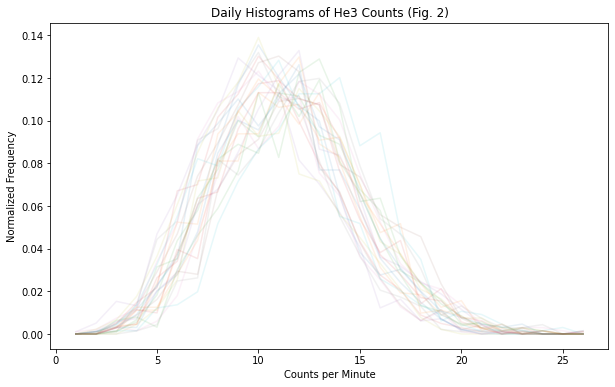

In [ ]:
fig_counter += 1 

# Ensure datetime index
he3_all.index = pd.to_datetime(he3_all.index)

# Temporarily rename the column for ease
counts_series = he3_all["Counts ch50-1000"]

# Group by day
grouped_by_day = counts_series.groupby(he3_all.index.date)

# Define bins
bins = np.arange(counts_series.min(), counts_series.max() + 1, 1)

# Plot histograms as line plots
plt.figure(figsize=(10, 6))

for day, group in grouped_by_day:
    hist_values, bin_edges = np.histogram(group, bins=bins, density=True)
    plt.plot(bin_edges[:-1], hist_values, alpha=0.1, label=str(day))

plt.xlabel("Counts per Minute")
plt.ylabel("Normalized Frequency")
plt.title(f"Daily Histograms of He3 Counts (Fig. {fig_counter})")
plt.show()


Let us quickly comment on how to read this plot:

- Each colored line corresponds to one calendar day’s distribution of neutron counts per minute.
- Horizontal axis: number of counts detected in a 1 min bin (i.e. $n$ counts per minute, with $n$ the numbers on the horizontal axis).
- Vertical axis: normalized frequency (so that areas under each curve sum to 1).
- The shading/transparency helps you see where multiple days’ distributions overlap. Each color corresponds to the data from a different day.

## Side-step 4.1 Expected Poisson Distribution

In order to conduct a statistical analysis on these background counts, we need to have an idea of what qualifies as a "significant" deviation from background. This will be of interest when trying to determine whether or not we have detected a "significant" number of neutron counts.

## Fitting to a Poisson distribution

Neutron background counts are typically modeled by a Poisson distribution because they arise from random, independent events which occur at a constant average rate over time. Our experimental setup aligns with the conditions under which the Poisson distribution is valid:

- Rare Events: Background neutrons are detected infrequently and individually; each detection is a discrete event.

- Statistical Independence: The arrival of one neutron does not affect the probability of another arriving.

- Constant Rate: Over short timescales (like 1-minute bins), the average background rate is approximately constant.

- Fixed Observation Interval: Counts are measured over uniform time intervals (i.e. counted over fixed 1 minute intervals).

Under these conditions, the number of neutrons detected in a fixed time interval should follow a Poisson distribution with mean $\lambda$, where $\lambda$ is the expected number of events (neutrons) per interval.

The standard deviation of the ditribution would thus be $\sigma = \sqrt{λ}$.

Furthermore, in the literature, we will typically consider that count is "significantly high" if it exceeds $\lambda + \sqrt{\lambda}\cdot Z$

where $Z = 3$ corresponds to a $3\sigma$ threshold (confidence level ~$99.7\%$)

Let us now have a closer look at how close our experimental background measurements are to a Poisson distribution, and extract its key statistical features.

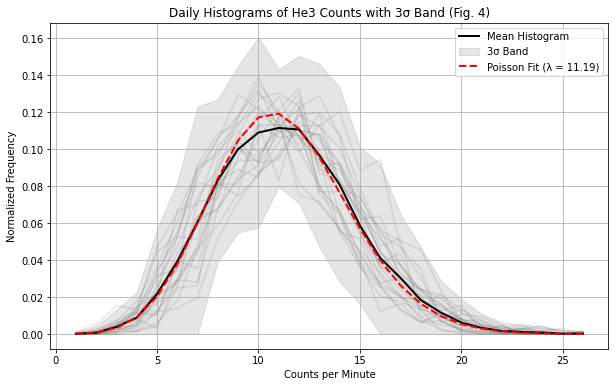

In [19]:
from scipy import stats

fig_counter += 1  

# Ensure the index is datetime
he3_all.index = pd.to_datetime(he3_all.index)

# Extract counts column
counts_series = he3_all["Counts ch50-1000"]

# Group by day
grouped_by_day = counts_series.groupby(he3_all.index.date)

# Define histogram bins
bins = np.arange(counts_series.min(), counts_series.max() + 1, 1)

# Compute histograms per day
histograms = []
for day, group in grouped_by_day:
    hist_values, bin_edges = np.histogram(group, bins=bins, density=True)
    histograms.append(hist_values)

# Convert to array and compute mean and standard deviation
histograms = np.array(histograms)
mean_histogram = np.mean(histograms, axis=0)
std_histogram = np.std(histograms, axis=0)

# Estimate Poisson background mean
lambda_ = counts_series.mean()
threshold_3sigma = lambda_ + 3 * np.sqrt(lambda_)

# Compute Poisson fit
k_values = bin_edges[:-1]
poisson_pmf = stats.poisson.pmf(k_values, mu=lambda_)

# Normalize Poisson PMF to match area of mean histogram
poisson_pmf_normalized = poisson_pmf / np.sum(poisson_pmf)
poisson_pmf_normalized *= np.sum(mean_histogram)

# Plotting
plt.figure(figsize=(10, 6))

# Plot all daily histograms
for hist_values in histograms:
    plt.plot(bin_edges[:-1], hist_values, alpha=0.2, color='gray')

# Plot mean histogram
plt.plot(bin_edges[:-1], mean_histogram, color='black', linewidth=2, label='Mean Histogram')

# Plot 3σ band
plt.fill_between(bin_edges[:-1],
                 np.maximum(mean_histogram - 3 * std_histogram, 0),
                 mean_histogram + 3 * std_histogram,
                 color='black', alpha=0.1, label='3σ Band')

# Plot Poisson fit
plt.plot(k_values, poisson_pmf_normalized, 'r--', linewidth=2, label=f'Poisson Fit (λ = {lambda_:.2f})')

plt.xlabel("Counts per Minute")
plt.ylabel("Normalized Frequency")
plt.title(f"Daily Histograms of He3 Counts with 3σ Band (Fig. {fig_counter})")
plt.legend()
plt.grid(True)
plt.show()


Let's take a step back to understand the graph we are looking at above.

The black line corresponds to the average distribution of neutron counts across all days.

The grey shaded area shows the spread of day-to-day variation, with upper and lower bounds at $3$ standard deviations above and below the mean. Days that would lie outside this band would be statistically rare under normal conditions (probability < $0.3\%$). Hence, we may identify neutron bursts in future runs by looking at "outliers" of this grey shaded area.

The red dashed line corresponds to the theoretical distribution assuming that neutron counts follow a Poisson process. We plotted this normalized Poisson ditribution assuming the Poisson paramter $\lambda$ to me the mean of our background data i.e. $\lambda \approx 11.19$.

## Quantitative goodness-of-fit

In order to test more rigorously whether our background truly follows a Poisson process, we can perform a $χ^2$ (chi-square) goodness-of-fit test comparing the observed mean histogram to the expected Poisson probabilities:

1. Compute the test statistic  
   $$
     \chi^2 = \sum_{k} \frac{(O_k - E_k)^2}{E_k},
   $$
   where $O_k$ are the observed counts in bin $k$ (from the mean histogram) and $E_k = N_{\rm tot}\,P_{\rm Poisson}(k;\lambda)$.  
2. Under the null hypothesis (data ∼ Poisson\($\lambda)$, $\chi^2$ follows a $\chi^2$ distribution with $\text{Degrees of Freedom} = \text{number of bins} - 1 - 1$ (subtracting one for the estimated $\lambda$ and 1 for normalization).  
3. A large $p$-value $(p>0.05$) implies we cannot reject the Poisson hypothesis at the $5 \%$ level.

In the code below, we conduct this goodness of fit analysis and find a p value of $p = 1$ so we cannot reject the null-hypothesis. Hence, for our purposes, we are in a good position to say that background follows a Poisson process.

In [24]:
# Aggregate observed counts across all days
O_counts = histograms.sum(axis=0)       # observed total counts per bin
N_tot = O_counts.sum()                         # total number of 1-min intervals

# Expected counts under Poisson(λ)
pk = stats.poisson.pmf(k_values, mu=lambda_)
E_counts = N_tot * pk

# Compute χ² statistic and p-value
chi2_stat = np.sum((O_counts - E_counts)**2 / E_counts)
dof = len(k_values) - 2  # degrees of freedon = bins minus 1 (normalization) minus 1 (λ estimated)
p_value = stats.chi2.sf(chi2_stat, dof)

print(f"Chi-square statistic: {chi2_stat:.2f}")
print(f"Degrees of freedom: {dof}")
print(f"p-value: {p_value:.10f}")

if p_value > 0.05:
    print("Cannot reject Poisson(λ) at the 5% significance level.")
else:
    print("Data significantly deviate from Poisson(λ).")


Chi-square statistic: 0.11
Degrees of freedom: 24
p-value: 1.0000000000
Cannot reject Poisson(λ) at the 5% significance level.


## Side-Step 4.2 Stability of the Background Rate and Normality of Daily Means

## Fitting to a Normal Distribution

Furthermore, before trusting the aformentioned single global $\lambda$, we should check how much the daily average neutron count per minute varies over our measurement period, and whether those daily means themselves follow an approximately normal distribution (by the Central Limit Theorem, if $\lambda$ is truly constant).

Daily mean counts per minute: μ = 11.30, σ = 0.75


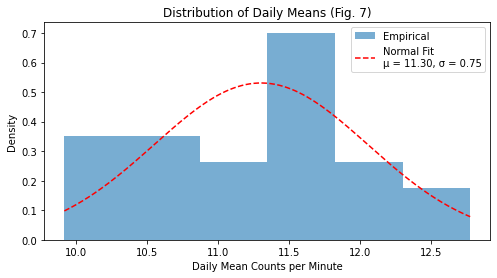

In [27]:
fig_counter += 1

# Ensure datetime index
he3_all.index = pd.to_datetime(he3_all.index)

# Extract counts
counts_series = he3_all["Counts ch50-1000"]

# Group by day
grouped_by_day = counts_series.groupby(he3_all.index.date)

# 1. Compute daily means
daily_means = [group.mean() for _, group in grouped_by_day]
days = list(grouped_by_day.groups.keys())

# 2. Summary statistics
mu_daily = np.mean(daily_means)
sigma_daily = np.std(daily_means)
print(f"Daily mean counts per minute: μ = {mu_daily:.2f}, σ = {sigma_daily:.2f}")

# 3. Histogram of daily means with Normal fit overlay
plt.figure(figsize=(8, 4))

# Histogram
vals, edges, _ = plt.hist(daily_means, bins='auto', density=True, alpha=0.6, label='Empirical')

# Normal PDF
x = np.linspace(min(edges), max(edges), 200)
pdf = stats.norm.pdf(x, loc=mu_daily, scale=sigma_daily)
plt.plot(x, pdf, 'r--', label=f'Normal Fit\nμ = {mu_daily:.2f}, σ = {sigma_daily:.2f}')

plt.xlabel('Daily Mean Counts per Minute')
plt.ylabel('Density')
plt.title(f'Distribution of Daily Means (Fig. {fig_counter})')
plt.legend()
plt.show()


## Quantitative goodness-of-fit

The above plot does not shed enough light on how close our mean distribution is to a normal distribution. In order to determine the quantitative goodness of our fit, we may start with a graphical check: the QQ-plot. This plot sample quantiles vs theoretical normal quantiles; and deviations from the straight line highlight non-normality.

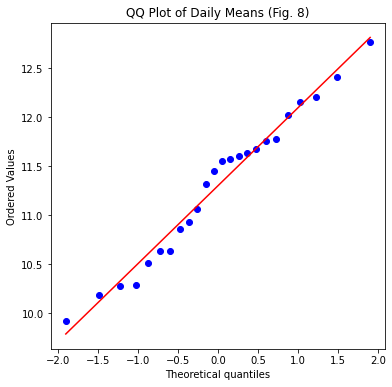

In [28]:
fig_counter += 1

# 4. QQ-plot for normality check
plt.figure(figsize=(6, 6))
stats.probplot(daily_means, dist="norm", plot=plt)
plt.title(f'QQ Plot of Daily Means (Fig. {fig_counter})')
plt.show()

The plot above shows us that the experimental distribution is fairly "linearly" close to a normal distribution. However, is not a good enough "quantitative" measure of the goodness of our fit. For this, we will perform the Shapiro-Wilk test.

The Shapiro–Wilk test computes a statistic  
$$
W \;=\; \frac{\bigl(\sum_{i=1}^n a_i\,x_{(i)}\bigr)^2}
                {\sum_{i=1}^n\bigl(x_i - \bar x\bigr)^2}\,,
$$  

where the $x_{(i)}$ are the ordered sample values, the $a_i$ are constants derived from the means and covariances of order statistics of a normal distribution, and $\bar x$ is the sample mean.  Under the null hypothesis that the data come from a normal distribution, $W$ is close to 1; values substantially below 1 indicate departure from normality.

In practice, we obtain from `scipy.stats.shapiro(daily_means)` both the test statistic $W$ and a $p$-value.  We then compare the $p$-value to our significance level (commonly $\alpha=0.05$):

- If $p > 0.05$, we **fail to reject** the null hypothesis: there is no strong evidence against normality.
- If $p \le 0.05$, we **reject** the null hypothesis: the daily means significantly deviate from a normal distribution.

In [29]:
# 5. Shapiro–Wilk test for normality
W, p_value = stats.shapiro(daily_means)
print(f"Shapiro–Wilk test: W = {W:.4f}, p-value = {p_value:.4f}")

if p_value > 0.05:
    print("Fail to reject H₀: data are consistent with a normal distribution")
else:
    print("Reject H₀: data significantly deviate from normality")

Shapiro–Wilk test: W = 0.9704, p-value = 0.6773
Fail to reject H₀: data are consistent with a normal distribution


By combining the visual Q–Q plot and the Shapiro–Wilk test, we obtain both qualitative and quantitative assurance that our daily means are well-approximated by a normal distribution. Hence, we may me confident in using a single global $\lambda$ for the background rate.  

So, it is a reasonable assumption to claim that our $\lambda$ is essentially constant over the January-December background collection period.

## Side-Step 4.3 Comparing our Background Rates with the Literature


### Reference Neutron Background Flux

For benchmarking our Eljen detector measurements against a well-established baseline, we will start by adopting the sea-level cosmic-ray neutron flux measured by [Gordon et al. (2004)](https://ieeexplore.ieee.org/document/1369506) on the roof of the IBM T. J. Watson Research Center in Yorktown Heights, NY:

> **Φ<sub>ref</sub> = 0.0134 n cm<sup>−2</sup> s<sup>−1</sup>**  

This value was Measured at ∼20 m a.s.l., geomagnetic cutoff ≃ 3 GV, and mid-level solar activity. In their paper, Gordon et al. provided corrections for different coordinates, altitudes, geomagnetic cutoffs and solar activity.

Hence, we will follow the equations given in the paper, and adapt to our experimental conditions, adjusting for location, environmental parameters, and detector efficiency in order to define a value for the expected background neutron flux from cosmic-rays.

Let us begin by applying a site-adjustment,  i.e.
   - Apply the altitude-dependence correction ([Gordon et al. (2004)](https://ieeexplore.ieee.org/document/1369506) Eq. (4)) to account for our [lab elevation]( https://elevation.maplogs.com/poi/massachusetts_institute_of_technology_77_massachusetts_ave_cambridge_ma_usa.197544.html).  
   - Apply [geomagnetic-rigidity](https://www.spenvis.oma.be/models.php) and [solar-modulation](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2016JA023819) corrections ([Gordon et al. (2004)](https://ieeexplore.ieee.org/document/1369506) Eqs. (3) & (5)) for our latitude and current solar cycle.

   
NB: *The hyper-links above correspond to references for the sources of the figures we will use for adaptiation to our specific experimental environment.*
